<a href="https://colab.research.google.com/github/Juanba98/Carlini-Wagner_L2/blob/main/Carlini%26Wagner_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


# Carlini-Wagner attack (http://arxiv.org/abs/1608.04644)

## L2 attack
To ensure the modifitacions yields to a valid image, we use the third method of box contraints at the paper and we define  $\delta$ as:

$$\delta_{i} = \frac{1}{2}(tanh(w_{i}) + 1) - x_{i} $$

and we optimize over the variable $w$



### Attack

Given x, and choosing a target class $t$  ($t \neq C^{*}(x)$, beeing $C^{*}(x)$) the correct label of x we search for a $w$ that solves



$$minimize \ ||\delta||^{2}_{2} + c \cdot f(x + \delta)$$ 



with $f$ defined as

$$f(x') = max(max\{Z(x')_i :  i \neq t\} - Z(x')_t, -\kappa)$$

To control the confidence with which missclasifation ocurrs we adjust κ but we wil set it to 0 for out attack

### L2 formula

$$||x||_{2} = \sqrt{\sum_{i=1}^{n} x^{2}_{i}} $$

## Referential implementation:
- https://github.com/carlini/nn_robust_attacks.git
- https://github.com/kkew3/pytorch-cw2/blob/master/cw.py

# Imports

In [2]:
import operator as op

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim



from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch.nn.functional as F
import matplotlib.pyplot as plt

#PATHS
from importlib.machinery import SourceFileLoader
from os.path import join
paths = SourceFileLoader('paths', '/content/paths.py').load_module()


#Utils

In [3]:
def show(imgs, gray = False):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        if(gray):
            axs[0, i].imshow(np.asarray(img).reshape(28,28),cmap="gray")
        else:
          axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def unNormalize (mean, std):

  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0. for x in mean],
                                                std = [ 1/x for x in std]),
                          transforms.Normalize(mean = [ -x for x in mean],
                                                std = [ 1. for x in std]),
                          ])

  return invTrans

# Device to use

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Hyperparameters

In [5]:
SEARCH_STEPS = 9         # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
K = 0                    # (kappa) how strong the adversarial example should be (confidence)
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

In [6]:


class L2Adversary(object):
  
 
  def __init__(self, targeted=True, k=K, c_range=(INITIAL_CONST, 1e10),
                  search_steps=SEARCH_STEPS, max_steps=1000, abort_early=ABORT_EARLY,
                  box=(-1., 1.), learning_rate = LEARNING_RATE):


  
    self.targeted = targeted # type: bool param: True for targeted attack
    self.k = float(k) #type: int param: confidence
    self.c_range = (float(c_range[0]), float(c_range[1])) # type: Tuple[float, float], param: range of the constat c
    self.binary_search_steps = search_steps #type: int param: number of steps to perform binary search to find optimal c
    self.max_steps = max_steps #type: int param: Maximum number of iterations
    self.abort_early = abort_early #type bool param: If true, we break when the gradient descent gets stuck
    self.box = tuple(map(float, box))  # type: Tuple[float, float], param: (max,min) pixel value
    self.learning_rate = learning_rate #type: float param: the learning rate for Adam optimizer used over the perturbation
    self.ae_tol = 1e-4  # tolerance of early abort
    
    
    self.repeat = (self.binary_search_steps >= 10)

    #Used for the affine transformation fo the change-of-variable
    self.box_mul = (self.box[1]-self.box[0])/2
    self.box_plus = (self.box[1]+self.box[0])/2

  def attack(self,model, inputs, targets, num_classes ):


    '''
    :param model: Model to attack :type: nn.Module  
    :param inputs: original images of dimension [B x C x H x W].
    :param targets: the original image labels, or the attack target, of
              dimension [B]. If ``self.targeted`` is ``True``, then ``targets``
              is treated as the attack targets, otherwise the labels.
              :type: torch.Tensor
    :param num_clases: number of clases of the model :type: int  
    :return: Adversarial examples of dimension [B X C x H x W]
    '''


    # sanity check
    assert isinstance(model, nn.Module)
    assert len(inputs.size()) == 4
    assert len(targets.size()) == 1


    # get a copy of targets in numpy before moving to GPU, used when doing
    # the binary search on `scale_const`
    targets_np = targets.clone().cpu().numpy().astype(int)  # type: np.ndarray

    # we move the tensor to the same device as the model 
    inputs = inputs.to(device)  # type: torch.FloatTensor
    targets = targets.to(device)  # type: torch.FloatTensor 


    batch_size = targets.size()[0]  # type: int
 
    # `lower_bounds_np`, `upper_bounds_np` and `scale_consts_np` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds_np < scale_consts_np <= upper_bounds_np
    lower_bounds_np = np.zeros(batch_size)
    upper_bounds_np = np.ones(batch_size) * self.c_range[1]
    scale_consts_np = np.ones(batch_size) * self.c_range[0]

   

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`: the least L2 norms
    # - `o_best_l2_ppred`: the perturbed predictions made by the adversarial
    #    perturbations with the least L2 norms
    # - `o_best_advx`: the underlying adversarial example of
    #   `o_best_l2_ppred`
    o_best_l2 = np.ones(batch_size) * np.inf #dimension [B]
    o_best_l2_ppred = -np.ones(batch_size) #dimension [B]
    o_best_advx = inputs.clone().cpu().numpy()  # type: np.ndarray dimension [B x C x H x W]
    
    # convert `inputs` to tanh-space
    #https://pytorch.org/docs/stable/generated/torch.atanh.html
    inputs_tanh = torch.atanh((inputs - self.box_plus) / self.box_mul)
    

    

    # the one-hot encoding of `targets`
    targets_oh = torch.zeros(targets.size() + (num_classes,) ,requires_grad = False)  # type: torch.FloatTensor


    #targets.unsqueeze(1) type:torch.FloatTensor but scatter need a LongTensor as a index 
    targets_oh.scatter_(1, targets.unsqueeze(1).type('torch.LongTensor'), 1.0)

    targets_oh = targets_oh.to(device)
    

   
    #the perturbation in tanh-space
    pert_tanh = nn.Parameter(torch.zeros_like(inputs))  # type: torch.FloatTensor

    
    optimizer = optim.Adam([pert_tanh], lr=self.learning_rate)
    

    for outer_step  in range(self.binary_search_steps):

      
      if self.repeat and outer_step == self.binary_search_steps - 1:
        scale_consts_np = upper_bounds_np

      
      #We convert the np.array to a tensor
      scale_consts = torch.tensor(np.copy(scale_consts_np)).float()  # type: torch.FloatTensor
      scale_consts = scale_consts.to(device)
      print('Using scale consts:', list(scale_consts_np))

     
      # the minimum L2 norms of perturbations found during optimization
      best_l2 = np.ones(batch_size) * np.inf

      # the perturbed predictions corresponding to `best_l2`, to be used
      # in binary search of `scale_const`
      best_l2_ppred = -np.ones(batch_size)

      # previous (summed) batch loss, to be used in early stopping policy
      prev_batch_loss = np.inf  # type: float

      for optim_step in range(self.max_steps):

        batch_loss, pert_norms_np, pert_outputs_np, advxs_np = \
            self._optimize(model, optimizer, inputs_tanh,
                            pert_tanh,  targets_oh,
                            scale_consts)
            
        if optim_step % 10 == 0: print(f'batch {optim_step} loss: {batch_loss}')  

        if self.abort_early and not optim_step % (self.max_steps // 10):

            #If loss increse enough we abort
            if batch_loss > prev_batch_loss * (1 - self.ae_tol):
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions_np = np.argmax(pert_outputs_np, axis=1)

      
        comp_pert_predictions_np = np.argmax(
                self._compensate_confidence(pert_outputs_np,
                                            targets_np),
                axis=1)
       
        #for each image
        for i in range(batch_size):

            l2 = pert_norms_np[i]
            cppred = comp_pert_predictions_np[i]
            ppred = pert_predictions_np[i]
            tlabel = targets_np[i]
            ax = advxs_np[i]
            if self._attack_successful(cppred, tlabel):
                assert cppred == ppred
                if l2 < best_l2[i]:
                    best_l2[i] = l2
                    best_l2_ppred[i] = ppred
                if l2 < o_best_l2[i]:
                    o_best_l2[i] = l2
                    o_best_l2_ppred[i] = ppred
                    o_best_advx[i] = ax




      # binary search of `scale_const`
      for i in range(batch_size):
          tlabel = targets_np[i]
          assert best_l2_ppred[i] == -1 or \
                  self._attack_successful(best_l2_ppred[i], tlabel)
          assert o_best_l2_ppred[i] == -1 or \
                  self._attack_successful(o_best_l2_ppred[i], tlabel)
          if best_l2_ppred[i] != -1:
              # successful; attempt to lower `scale_const` by halving it
              if scale_consts_np[i] < upper_bounds_np[i]:
                  upper_bounds_np[i] = scale_consts_np[i]
              # `upper_bounds_np[i] == c_range[1]` implies no solution found
             
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
          else:
              # failure; multiply `scale_const` by ten if no solution
              # found; otherwise do binary search
              if scale_consts_np[i] > lower_bounds_np[i]:
                  lower_bounds_np[i] = scale_consts_np[i]
              if upper_bounds_np[i] < self.c_range[1] * 0.1:
                  scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
              else:
                  scale_consts_np[i] *= 10

    #if not to_numpy:
    o_best_advx = torch.from_numpy(o_best_advx).float()
    return o_best_advx 




  def _optimize(self, model, optimizer, inputs_tanh_var, pert_tanh_var,
                  targets_oh_var, c_var):
        """
        Optimize for one step.
        :param model: the model to attack
        :type model: nn.Module
        :param optimizer: the Adam optimizer to optimize pert_tanh
        :type optimizer: optim.Adam
        :param inputs_tanh_var: the input images in tanh-space
        :type inputs_tanh_var: torch.FloatTensor
        :param pert_tanh_var: the perturbation to optimize in tanh-space
        :type pert_tanh_var: torch.FloatTensor
        :param targets_oh_var: the one-hot encoded target tensor (the attack
               targets if self.targeted else image labels)
        :type targets_oh_var: torch.FloatTensor
        :param c_var: the constant `c` for each perturbation of a batch,
               a Variable of FloatTensor of dimension [B]
        :type c_var: torch.FloatTensor
        :return: the batch loss, squared L2-norm of adversarial perturbations
                 (of dimension [B]), the perturbed activations (of dimension
                 [B]), the adversarial examples (of dimension [B x C x H x W])
        """


        # the adversarial examples in the image space
        # of dimension [B x C x H x W]
        advxs_var = torch.tanh(inputs_tanh_var + pert_tanh_var) * self.box_mul + self.box_plus 
        advxs_var.to(device)
       

        # Do optimization for one step
        optimizer.zero_grad()

        # the perturbed activation before softmax
        pert_outputs_var = model(advxs_var)  
        

        # the original inputs
        inputs_var = torch.tanh(inputs_tanh_var) * self.box_mul + self.box_plus  # type: torch.FloatTensor
        


        #L2 norm Squared dimension [B]
        perts_norm_var = torch.pow(advxs_var - inputs_var, 2)
        perts_norm_var = torch.sum(perts_norm_var.view(
                perts_norm_var.size(0), -1), 1)
        
      

        
        #Z(t)
        # Z() the output of all layers except the softmax
        # t attack target or the image label
        target_activ_var = torch.sum(targets_oh_var * pert_outputs_var, 1)
        inf = 1e4  
     
        assert (pert_outputs_var.max(1)[0] >= -inf).all(), 'assumption failed'
       

        # compute the probability of the label class versus the maximum other
        # max(Z(x')_i : i not equal t)
        maxother_activ_var = torch.max(((1 - targets_oh_var) * pert_outputs_var
                                        - targets_oh_var * inf), 1)[0]

        # Compute f(x'), where x' is the adversarial example in image space.
        # The result f_var should be of dimension [B]
        if self.targeted:
            # if targeted, optimize to make `target_activ_var` larger than
            # maxother_activ_var by self.k
            f_var = torch.clamp(maxother_activ_var - target_activ_var
                                + self.k, min=0.0)
        else:
            # if not targeted, optimize to make maxother_activ_var larger than
            # target_activ_var (the ground truth image labels) by
            # self.k
            f_var = torch.clamp(target_activ_var - maxother_activ_var
                                + self.k, min=0.0)
            

        # the total loss of current batch, should be of dimension [1]
        loss = torch.sum(perts_norm_var + c_var * f_var)
        

        #Back propagation
        loss.backward()
        #Updates the parameters
        optimizer.step()

        
        # Make some records in python/numpy on CPU
        batch_loss = loss.data  # type: float
        pert_norms_np = perts_norm_var.data.cpu().numpy()
        pert_outputs_np = pert_outputs_var.data.cpu().numpy()
        advxs_np = advxs_var.data.cpu().numpy()
        return batch_loss, pert_norms_np, pert_outputs_np, advxs_np

  # noinspection PyUnresolvedReferences
  def _compensate_confidence(self, outputs, targets):
      """
      Compensate for self.k and returns a new weighted sum
      vector.
      :param outputs: the weighted sum right before the last layer softmax
              normalization, of dimension [B x M]
      :type outputs: np.ndarray
      :param targets: either the attack targets or the real image labels,
              depending on whether or not ``self.targeted``, of dimension [B]
      :type targets: np.ndarray
      :return: the compensated weighted sum of dimension [B x M]
      :rtype: np.ndarray
      """
      outputs_comp = np.copy(outputs)
      rng = np.arange(targets.shape[0])

      if self.targeted:
          # for each image i:
          # if targeted, outputs[i, target_onehot] (target) should be larger than
          # max(outputs[i, ~target_onehot]) (max (~target)) by self.k
          # The target label should be larger than
          
          outputs_comp[rng, targets] -= self.k
      else:
          # for each image $i$:
          # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
          # than `outputs[i, target_onehot]` (the ground truth image labels)
          # by `self.k`
          outputs_comp[rng, targets] += self.k


      return outputs_comp


  def _attack_successful(self, prediction, target):
    """
    See whether the underlying attack is successful.
    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
   
    if self.targeted:
        return prediction == target
    else:
        return prediction != target



# CifarCNN

## Load Data

In [7]:

mean = [0.5,0.5,0.5]
std =  [0.5,0.5,0.5]

batch_size = 4

dataloader = torch.utils.data.DataLoader(datasets.CIFAR10(root = '/content/CIFAR10', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean = mean, std = std),
                           ])),  shuffle=True, batch_size = batch_size, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


NUM_CLASSES = len(classes)


Files already downloaded and verified


## Neural Network

In [8]:
class CifarCNN(nn.Module):

    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 10)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.conv4(h)))
        h = F.max_pool2d(h, 4)

        h = F.relu(self.fc5(h.view(h.size(0), -1)))
        h = F.relu(self.fc6(h))
        h = self.fc7(h)
        return F.log_softmax(h)

model = CifarCNN()

## Training

In [9]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.771
[1,  4000] loss: 1.446
[1,  6000] loss: 1.291
[1,  8000] loss: 1.168
[1, 10000] loss: 1.092
[1, 12000] loss: 1.035
[2,  2000] loss: 0.948
[2,  4000] loss: 0.913
[2,  6000] loss: 0.867
[2,  8000] loss: 0.851
[2, 10000] loss: 0.833
[2, 12000] loss: 0.833
Finished Training


In [10]:
PATH = paths.CIFAR10_DIR
torch.save(model.state_dict(), PATH)

## Attack

In [11]:
PATH = paths.CIFAR10_DIR
model.load_state_dict(torch.load(PATH))

model.to(device)


inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


inputs, labels = next(iter(dataloader)) #inputs images
inputs.to(device)
target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded


adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


Using scale consts: [0.001, 0.001, 0.001, 0.001]
batch 0 loss: 0.017068203538656235
batch 10 loss: 0.017385855317115784
batch 20 loss: 0.01714087463915348
batch 30 loss: 0.017048507928848267
batch 40 loss: 0.0170392207801342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


batch 50 loss: 0.017036639153957367
batch 60 loss: 0.01703513041138649
batch 70 loss: 0.01703452691435814
batch 80 loss: 0.01703435182571411
batch 90 loss: 0.017034269869327545
batch 100 loss: 0.017034213989973068
batch 110 loss: 0.017034202814102173
batch 120 loss: 0.017034199088811874
batch 130 loss: 0.017034191638231277
batch 140 loss: 0.017034191638231277
batch 150 loss: 0.017034193500876427
batch 160 loss: 0.017034191638231277
batch 170 loss: 0.017034191638231277
batch 180 loss: 0.017034191638231277
batch 190 loss: 0.017034195363521576
batch 200 loss: 0.017034193500876427
Using scale consts: [0.01, 0.01, 0.01, 0.01]
batch 0 loss: 0.1700352132320404
batch 10 loss: 0.16771867871284485
batch 20 loss: 0.16742396354675293
batch 30 loss: 0.16732308268547058
batch 40 loss: 0.16728374361991882
batch 50 loss: 0.16727222502231598
batch 60 loss: 0.16726642847061157
batch 70 loss: 0.16727189719676971
batch 80 loss: 0.1672680675983429
batch 90 loss: 0.1672629714012146
batch 100 loss: 0.1672698

## Display Results

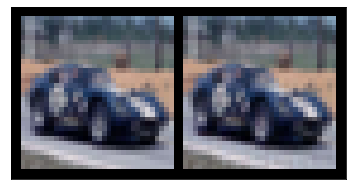

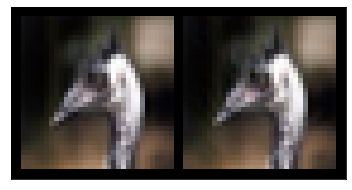

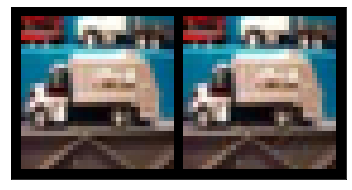

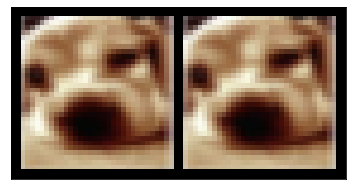

In [12]:
import torchvision as TV

for i in range(0,adversarial_examples.size()[0]):
 
  invTrans = unNormalize(mean,std)
  inv1 = invTrans(inputs[i])
  TV.utils.save_image(inv1, join(paths.CIFAR10_CW_LOGS,'%d_original.png' %(i)))
  inv2 = invTrans(adversarial_examples[i])
  TV.utils.save_image(inv2, join(paths.CIFAR10_CW_LOGS,'%d_adversarial.png' %(i)))
  list_img = [inv1, inv2]
  grid = utils.make_grid(list_img)
  show(grid)


#MNIST

## Load Data

In [13]:
mean = [0.5]
std= [0.5]
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content/MNIST', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                           ])),batch_size=9, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(root = '/content/MNIST', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(28),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5),
                           ])),batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw



## Neural Network

In [14]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 10, kernel_size=3, stride=3)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 10 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = MnistCNN()

## Training

In [15]:
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.209
[1,   400] loss: 0.135
[1,   600] loss: 0.080
[1,   800] loss: 0.056
[1,  1000] loss: 0.043
[1,  1200] loss: 0.035
[1,  1400] loss: 0.034
[1,  1600] loss: 0.029
[1,  1800] loss: 0.024
[1,  2000] loss: 0.024
[1,  2200] loss: 0.025
[1,  2400] loss: 0.022
[1,  2600] loss: 0.023
[1,  2800] loss: 0.019
[1,  3000] loss: 0.020
[1,  3200] loss: 0.020
[1,  3400] loss: 0.019
[1,  3600] loss: 0.019
[1,  3800] loss: 0.017
[1,  4000] loss: 0.020
[1,  4200] loss: 0.015
[1,  4400] loss: 0.020
[1,  4600] loss: 0.018
[1,  4800] loss: 0.015
[1,  5000] loss: 0.016
[1,  5200] loss: 0.014
[1,  5400] loss: 0.015
[1,  5600] loss: 0.015
[1,  5800] loss: 0.017
[1,  6000] loss: 0.017
[1,  6200] loss: 0.015
[1,  6400] loss: 0.012
[1,  6600] loss: 0.014
[2,   200] loss: 0.011
[2,   400] loss: 0.012
[2,   600] loss: 0.014
[2,   800] loss: 0.011
[2,  1000] loss: 0.013
[2,  1200] loss: 0.014
[2,  1400] loss: 0.013
[2,  1600] loss: 0.011
[2,  1800] loss: 0.013
[2,  2000] loss: 0.012
[2,  2200] 

In [16]:
PATH = '/content/drive/MyDrive/TFG/MNIST/MNIST_net.pth'
torch.save(model.state_dict(), paths.MNIST_DIR)

## Attack

In [17]:
model.load_state_dict(torch.load(paths.MNIST_DIR))

model.to(device)

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# a targeted adversary
adversary = L2Adversary(targeted=True,
                           k=0.0,
                           search_steps=10,
                           box=inputs_box,
                           learning_rate=5e-4)


dataiter = iter(train_loader) #inputs images
inputs, _ = dataiter.next()

inputs.to(device)

target_class_idx = 3
attack_targets = torch.ones(inputs.size(0)) * target_class_idx #target one-hot encoded

NUM_CLASSES = 10
adversarial_examples = adversary.attack(model, inputs, attack_targets, NUM_CLASSES)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()


Using scale consts: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
batch 0 loss: 0.10881832987070084
batch 10 loss: 0.10880525410175323
batch 20 loss: 0.1087951734662056
batch 30 loss: 0.10879106819629669
batch 40 loss: 0.10878986865282059
batch 50 loss: 0.10878928005695343
batch 60 loss: 0.10878895223140717
batch 70 loss: 0.10878876596689224
batch 80 loss: 0.10878866165876389
batch 90 loss: 0.10878859460353851
batch 100 loss: 0.10878854990005493
batch 110 loss: 0.10878852009773254
batch 120 loss: 0.10878851264715195
batch 130 loss: 0.10878849029541016
batch 140 loss: 0.10878848284482956
batch 150 loss: 0.10878849029541016
batch 160 loss: 0.10878847539424896
batch 170 loss: 0.10878848284482956
batch 180 loss: 0.10878849029541016
batch 190 loss: 0.10878847539424896
batch 200 loss: 0.10878847539424896
Using scale consts: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
batch 0 loss: 1.087616205215454
batch 10 loss: 1.0861847400665283
batch 20 loss: 1.08585202693939

## Display results 

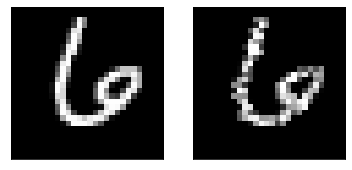

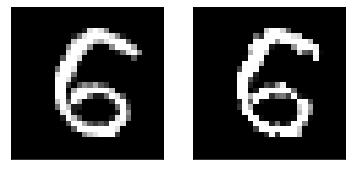

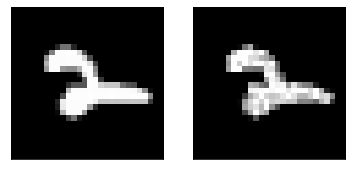

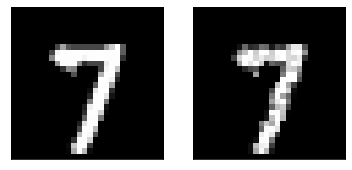

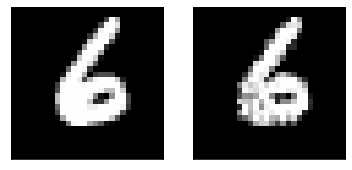

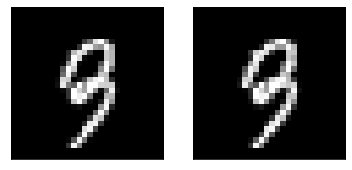

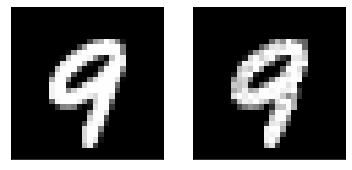

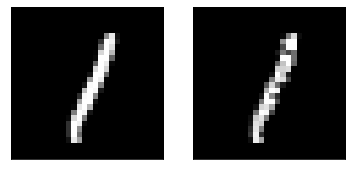

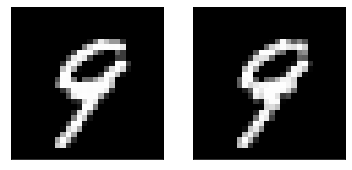

In [18]:
import torchvision as TV

for i in range(0,adversarial_examples.size()[0]):

  invTrans = unNormalize(mean,std)
  inv1 = invTrans(inputs[i])
  TV.utils.save_image(inv1.reshape(28,28), join(paths.MNIST_CW_LOGS, "%d_original.png" %(i)),)

  inv2 = invTrans(adversarial_examples[i]) 
  TV.utils.save_image(adversarial_examples[i].reshape(28,28), join(paths.MNIST_CW_LOGS, "%d_adversarial.png" %(i)))

  list_ad = [inv1,inv2]
  show(list_ad,gray=True)
  